<a href="https://colab.research.google.com/github/Rjpiit/Image-processing-and-Audio-Reconstruction/blob/master/Task3_super_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests

url = "https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg"
response = requests.get(url)

# Save the image
with open("image.jpg", "wb") as file:

    file.write(response.content)

print("Image downloaded successfully!")


Image downloaded successfully!


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 629.9 kB/s eta 0:00:000:00:01
Note: you may need to restart the kernel to use updated packages.


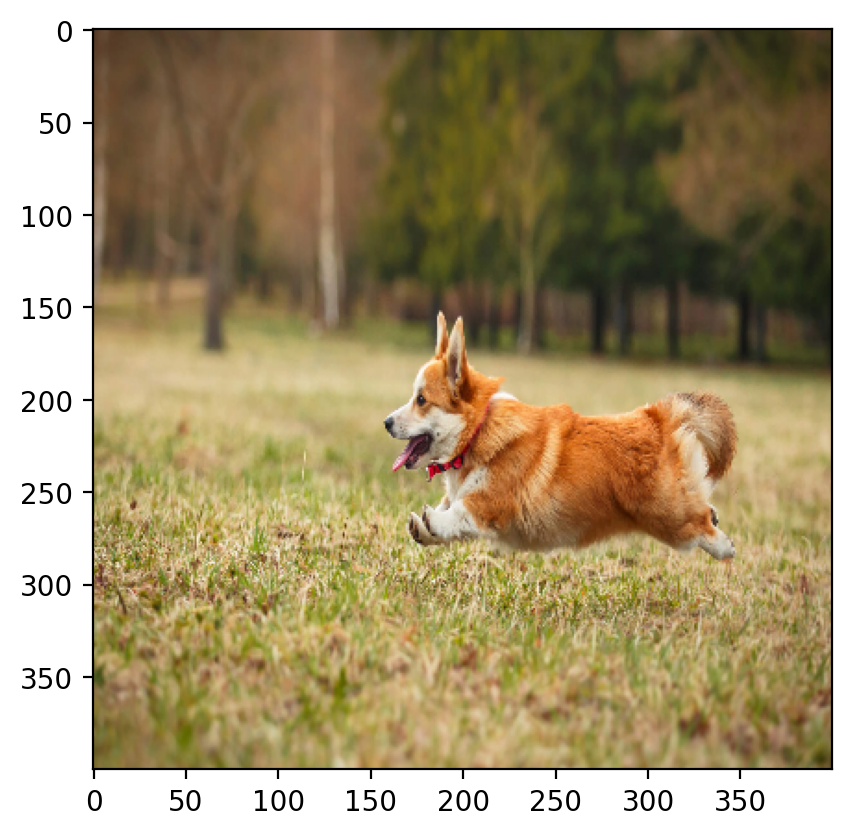

In [ ]:
import cv2

image = cv2.imread('image.jpg')

original_image = cv2.resize(image, (400, 400))

original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

plt.imshow(original_image_rgb)


In [ ]:
# resized_image = cv2.resize(image, (200, 200))

# resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

# plt.imshow(resized_image_rgb)


In [ ]:
import torchvision.transforms as T
img = T.ToTensor()(original_image_rgb )
print(img.shape)

torch.Size([3, 400, 400])


In [ ]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [ ]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3137, 0.3294, 0.3490,  ..., 0.2784, 0.2706, 0.2941],
         [0.3137, 0.3294, 0.3490,  ..., 0.2863, 0.2784, 0.3020],
         [0.3216, 0.3333, 0.3569,  ..., 0.2941, 0.2980, 0.2980],
         ...,
         [0.4745, 0.4824, 0.4941,  ..., 0.4196, 0.3843, 0.3647],
         [0.4745, 0.4863, 0.5020,  ..., 0.4314, 0.3922, 0.3765],
         [0.4784, 0.4941, 0.5059,  ..., 0.4392, 0.4000, 0.3804]],

        [[0.2078, 0.2235, 0.2431,  ..., 0.2235, 0.2275, 0.2157],
         [0.2078, 0.2235, 0.2431,  ..., 0.2314, 0.2353, 0.2235],
         [0.2157, 0.2275, 0.2510,  ..., 0.2392, 0.2314, 0.2314],
         ...,
         [0.4039, 0.4157, 0.4431,  ..., 0.3294, 0.3137, 0.2941],
         [0.4039, 0.4157, 0.4392,  ..., 0.3451, 0.3216, 0.3059],
         [0.4078, 0.4235, 0.4353,  ..., 0.3529, 0.3373, 0.3216]],

        [[0.1412, 0.1529, 0.1647,  ..., 0.1176, 0.1176, 0.1176],
         [0.1412, 0.1529, 0.1608,  ..., 0.1255, 0.1255, 0.1255],
         [0.1333, 0.1451, 0.1686,  ..., 0.1333, 0.1294, 0.

In [ ]:
img = img.to(device)

In [ ]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y



In [ ]:
img_X, img_Y = create_coordinate_map(img)

img_X.shape, img_Y.shape

(torch.Size([160000, 2]), torch.Size([160000, 3]))

In [ ]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(img_X.cpu())

# Scale the X coordinates
img_X_scaled = scaler_X.transform(img_X.cpu())

# Move the scaled X coordinates to the GPU
img_X_scaled = torch.tensor(img_X_scaled).to(device)

# Set to dtype float32
img_X_scaled = img_X_scaled.float()

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


In [ ]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()


In [ ]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)



In [ ]:
X_rff = create_rff_features(img_X_scaled, 15000, 0.008)
X_rff.shape

torch.Size([160000, 15000])

In [ ]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, img_Y, 1000)

Epoch 0 loss: 0.238386
Epoch 100 loss: 0.029246
Epoch 200 loss: 0.014816
Epoch 300 loss: 0.011012
Epoch 400 loss: 0.008496
Epoch 500 loss: 0.006716
Epoch 600 loss: 0.005435
Epoch 700 loss: 0.004506
Epoch 800 loss: 0.003831
Epoch 900 loss: 0.003339


0.0029830913990736008

In [ ]:
# net = LinearModel(X_rff.shape[1], 3)
# net.to(device)

# train(net, 0.005, X_rff, img_Y, 2500)

In [ ]:
img_Y.shape

torch.Size([160000, 3])

In [ ]:
def downsample_rff_features(rff_features, original_size=400, target_size=200):
    """
    Downsample RFF features from original_size x original_size to target_size x target_size.

    X_400_rff: torch.Tensor of shape (original_size * original_size, num_features)
    original_size: int, the original size (e.g., 400)
    target_size: int, the target size (e.g., 200)

    return: torch.Tensor of shape (target_size * target_size, num_features)
    """
    num_features = X_rff.shape[1]

    # Reshape from (original_size * original_size, num_features) to (original_size, original_size, num_features)
    rff_features_reshaped = X_rff.reshape(original_size, original_size, num_features)

    # Downsample: select every second point in both width and height
    rff_features_downsampled = rff_features_reshaped[::2, ::2, :]

    # Reshape back to (target_size * target_size, num_features)
    rff_features_downsampled = rff_features_downsampled.reshape(target_size * target_size, num_features)

    return rff_features_downsampled

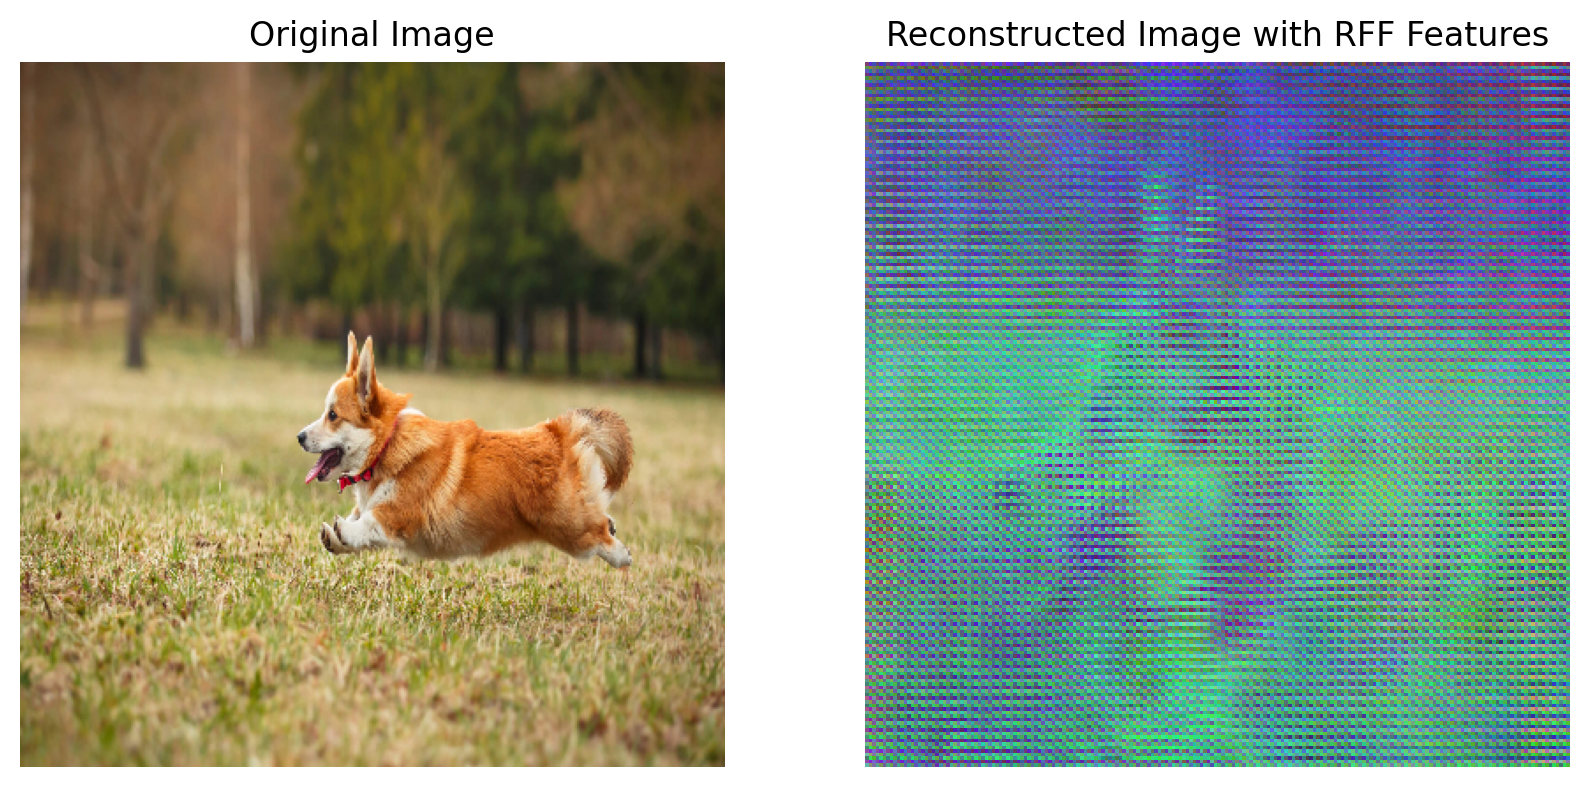

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_reconstructed_and_original_image(original_img, net, X, title="Reconstructed Image with RFF Features"):
    """
    Plot the original and reconstructed image side by side.
    original_img: The original image tensor (shape: (channels, height, width))
    net: The model used for prediction
    X: The RFF features input for the model (shape: (num_features,))
    title: The title of the plot
    """
    # Run the prediction using the model
    with torch.no_grad():
        outputs = net(X)  # Assuming the model accepts the RFF features as input

    # Assuming the output needs to be reshaped into (channels, height, width)
    reconstructed_height, reconstructed_width = 200, 200  # Adjust for the downscaled image

    if outputs.numel() == reconstructed_height * reconstructed_width:
        # Grayscale image (single channel)
        outputs = outputs.reshape(reconstructed_height, reconstructed_width)
        outputs = outputs.unsqueeze(0)  # Add a channel dimension for consistency
        cmap = 'gray'
    elif outputs.numel() == 3 * reconstructed_height * reconstructed_width:
        # RGB image (3 channels)
        outputs = outputs.reshape(3, reconstructed_height, reconstructed_width).permute(1, 2, 0)  # Reorder dimensions
        cmap = None  # No colormap for RGB

    # Normalize the output to ensure it's in [0, 1] range for RGB
    outputs = outputs - outputs.min()  # Shift to make the minimum value 0
    if outputs.max() != 0:
        outputs = outputs / outputs.max()  # Normalize to make the maximum value 1

    # Convert to numpy for plotting
    outputs_np = outputs.cpu().numpy()

    # Plot the original and reconstructed images side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the original image (assuming original_img is RGB or grayscale)
    if original_img.shape[0] == 3:  # RGB image
        ax[0].imshow(original_img.permute(1, 2, 0).cpu().numpy())
    else:  # Grayscale image
        ax[0].imshow(original_img.squeeze().cpu().numpy(), cmap='gray')

    ax[0].set_title("Original Image")
    ax[0].axis('off')

    # Plot the reconstructed image (ensure it's clipped to [0, 1] for RGB display)
    ax[1].imshow(np.clip(outputs_np, 0, 1), cmap=cmap)
    ax[1].set_title(title)
    ax[1].axis('off')

    plt.show()


# Example usage:

# Assume you have the following already prepared:
# - `rff_features`: The RFF features of the original 400x400 image (torch.Tensor of shape (400 * 400, num_features))
# - `original_img`: The original 200x200 image to compare with (torch.Tensor of shape (channels, height, width))
# - `net`: Your trained model that accepts RFF features as input and returns the reconstructed image
# - `num_features`: Number of RFF features

# Downsample the RFF features to 200x200 (ensure `downsample_rff_features` function is implemented)
X_downsampled = downsample_rff_features(X_rff, original_size=400, target_size=200)

# Pass the downsampled RFF features through the model to predict the image
plot_reconstructed_and_original_image(img, net, X_downsampled)


In [ ]:
original_img = cv2.resize(image, (200, 200))

In [ ]:
original_img.shape

(200, 200, 3)

In [ ]:
import torchvision.transforms as T
original_image_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
original_img = T.ToTensor()(original_image_rgb )


In [ ]:
img_X2, img_Y2 = create_coordinate_map(original_img)

img_X2.shape, img_Y2.shape

(torch.Size([40000, 2]), torch.Size([40000, 3]))

In [ ]:

from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr
def calculate_rmse(original, reconstructed):
    original = original.cpu().numpy().reshape(-1)
    reconstructed = reconstructed.cpu().numpy().reshape(-1)
    return np.sqrt(mean_squared_error(original, reconstructed))

def calculate_psnr(original, reconstructed):
    original = rearrange(original.cpu(), 'c h w -> h w c').numpy()
    reconstructed = reconstructed.cpu().numpy().reshape(original.shape)
    return psnr(original, reconstructed, data_range=original.max() - original.min())

In [ ]:
with torch.no_grad():
    reconstructed = net(X_downsampled).cpu()
rmse = calculate_rmse(img_Y2, reconstructed)
psnr_value = calculate_psnr(original_img, reconstructed)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr_value:.4f}")

Root Mean Squared Error (RMSE): 0.0575
Peak Signal-to-Noise Ratio (PSNR): 24.8092
